In [1]:
# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

In [2]:
authors = pd.read_csv("./nips-papers/authors.csv")
paper_authors = pd.read_csv("./nips-papers/paper_authors.csv")
papers = pd.read_csv("./nips-papers/papers.csv")

# Coauthorship network (2nd method)

## Preprocess the data: merge the paper, paper_authors and author tables

In [38]:
df_all = pd.merge(papers, paper_authors, left_on='id', right_on='paper_id', suffixes=('_paper',''))
df_all.drop(columns=['id_paper', 'id'], inplace=True)
df_all = pd.merge(df_all, authors, left_on='author_id', right_on='id')
df_all.drop(columns=['id'], inplace=True)
df_all.head(3)

year                                              title event_type  \
0  1987  Self-Organization of Associative Database and ...        NaN   
1  1987  Self-Organization of Associative Database and ...        NaN   
2  1987  A Mean Field Theory of Layer IV of Visual Cort...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
1  1-self-organization-of-associative-database-an...  Abstract Missing   
2  10-a-mean-field-theory-of-layer-iv-of-visual-c...  Abstract Missing   

                                          paper_text  paper_id  author_id  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...         1          1   
1  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...         1          2   
2  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...        10         14   

                      name  
0           Hisashi Suzuki  
1           Suguru Arimoto  
2  Christopher L. Scofield

## Construct the co-author network

In [39]:
self_merge = pd.merge(df_all, df_all, on='paper_id', suffixes=('_left', '_right'))
self_merge = self_merge[self_merge.name_left != self_merge.name_right]
self_merge.head(1)

year_left                                         title_left  \
1       1987  Self-Organization of Associative Database and ...   

  event_type_left                                      pdf_name_left  \
1             NaN  1-self-organization-of-associative-database-an...   

      abstract_left                                    paper_text_left  \
1  Abstract Missing  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   

   paper_id  author_id_left       name_left  year_right  \
1         1               1  Hisashi Suzuki        1987   

                                         title_right event_type_right  \
1  Self-Organization of Associative Database and ...              NaN   

                                      pdf_name_right    abstract_right  \
1  1-self-organization-of-associative-database-an...  Abstract Missing   

                                    paper_text_right  author_id_right  \
1  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...                2   

       name_right  
1  Suguru Arimoto

**Nodes represent the unique authors in the nips dataset between 1987 and 2018**

In [41]:
nodes = df_all[~df_all.name.duplicated()].reset_index(drop=True).reset_index()
print("The number of nodes in the co-author network is: ", len(nodes))
nodes.head(1)

The number of nodes in the co-author network is:  11630


index  year                                              title event_type  \
0      0  1987  Self-Organization of Associative Database and ...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   

                                          paper_text  paper_id  author_id  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...         1          1   

             name  
0  Hisashi Suzuki

**Numeric the author name in order to construct edges later**

In [42]:
name_index = nodes.name.to_dict()
name_index = {v: k for k, v in name_index.items()}
self_merge['source'] = self_merge.name_left.map(name_index)
self_merge['target'] = self_merge.name_right.map(name_index)
self_merge.head(1)

year_left                                         title_left  \
1       1987  Self-Organization of Associative Database and ...   

  event_type_left                                      pdf_name_left  \
1             NaN  1-self-organization-of-associative-database-an...   

      abstract_left                                    paper_text_left  \
1  Abstract Missing  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   

   paper_id  author_id_left       name_left  year_right  \
1         1               1  Hisashi Suzuki        1987   

                                         title_right event_type_right  \
1  Self-Organization of Associative Database and ...              NaN   

                                      pdf_name_right    abstract_right  \
1  1-self-organization-of-associative-database-an...  Abstract Missing   

                                    paper_text_right  author_id_right  \
1  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...                2   

       name_right  source  target  
1  Suguru Arimoto       0       1

**generate the co-author network according to the adjacency matrix   
the weight of the edge is the number of the papers two author published together**

In [43]:
def get_adjacency(nodes, edges):
    n_nodes = len(nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    for idx, row in edges.iterrows():
        i, j = int(row.source), int(row.target)
        adjacency[i, j] += 1

    return adjacency

adjacency = get_adjacency(nodes, self_merge)
graph = nx.from_numpy_array(adjacency)

**visualize the generate co-author network**

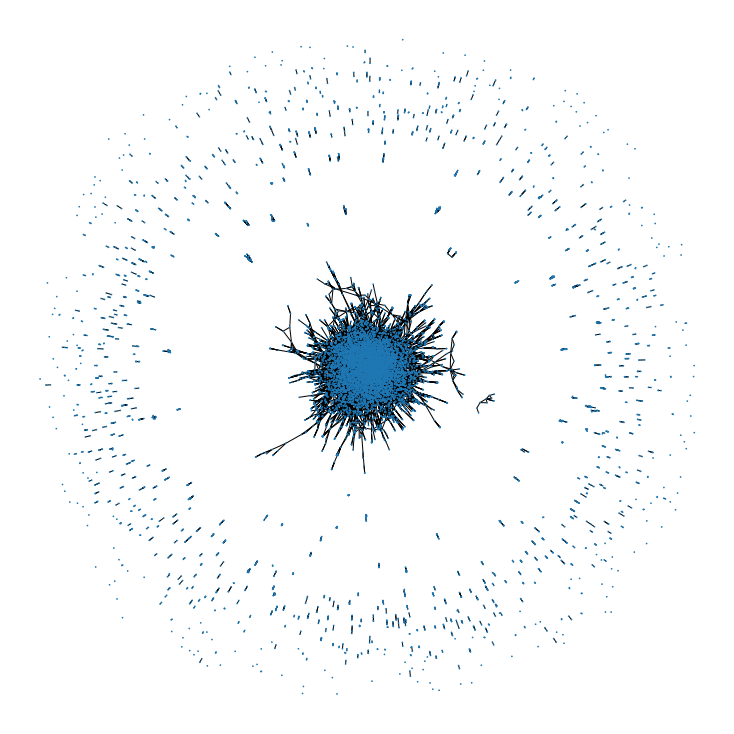

In [44]:
pos = nx.layout.fruchterman_reingold_layout(graph)
plt.figure(figsize=(10, 10))
nx.draw(graph, pos=pos, node_size=[0.5,0.5])

## Explore the co-author network

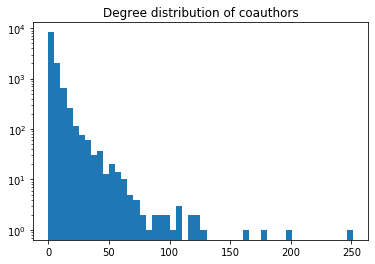

In [47]:
plt.title('Degree distribution of coauthors')
plt.hist(adjacency.sum(axis=1), bins=50, log=True)
plt.show()

**Observation**
1. We can observe that most nodes in the co-author network have small degrees
2. Only a few authors have large degrees
3. Most researchers have limited cooperation relationship between other researchers.

**calculate the component sizes of the co-author network**

In [51]:
component = pd.Series([len(i) for i in list(nx.connected_components(graph))]).value_counts().sort_index()
component = pd.DataFrame(component).reset_index()
component.columns = ['component_size', 'number of components']
component

component_size  number of components
0                1                   211
1                2                   291
2                3                   192
3                4                    95
4                5                    44
5                6                    26
6                7                    24
7                8                     7
8                9                     5
9               10                     2
10              11                     4
11              12                     4
12              13                     2
13              14                     2
14              16                     1
15              17                     1
16              18                     1
17              20                     1
18              21                     1
19            8978                     1

**Observation**
We can observe that there is only one largest component contains 8978 authors, and many small communities.

In [52]:
largest_cc = max(nx.connected_components(graph), key=len)
print(f'the largest component contains : {len(largest_cc)} authors')
print("The total number of components is: ", nx.number_connected_components(graph))

the largest component contains : 8978 authors
The total number of components is:  915


**explore the centrality of the largest component**  
Betweenness centrality is a measure of the influence of a vertex over the flow of information between every pair of vertices under the assumption that information primarily flows over the shortest paths between them. So here we use the betweenness_centrality to highlight nodes that function as "bridges" between people.

In [21]:
centrality = nx.betweenness_centrality(graph.subgraph(largest_cc))

**summary statistics of the centrality**

In [58]:
pd.Series(np.array(list(centrality.values()))).describe()

count    8978.000000
mean        0.000552
std         0.002876
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000151
max         0.142048
dtype: float64

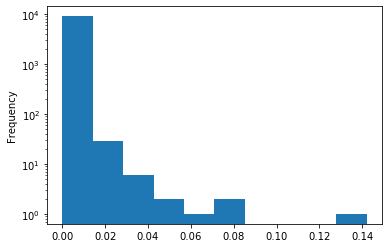

In [60]:
ax = pd.Series(np.array(list(centrality.values()))).plot.hist()
ax.set_yscale('log')

In [74]:
print("The lowest betweenness centrality of the top 0.25% nodes:", np.quantile(np.array(list(centrality.values())), 0.9975))

The lowest betweenness centrality of the top 0.25% nodes: 0.01905419168631666


**Observation**
1. The largest betweenness centrality of the co-author network is 0.142
2. Most nodes has the betweenness centrality value 0
3. We highlight the nodes with betweenness centrality of the top 0.25%

In [75]:
lables = nodes.name.to_dict()
lables = { key: lables[key] for (key, value) in centrality.items() if value > 0.01905419168631666}

In [76]:
# For visualize purpose, we enlarge the node size according to the centrality value
node_size = np.array(list(centrality.values()))*10000

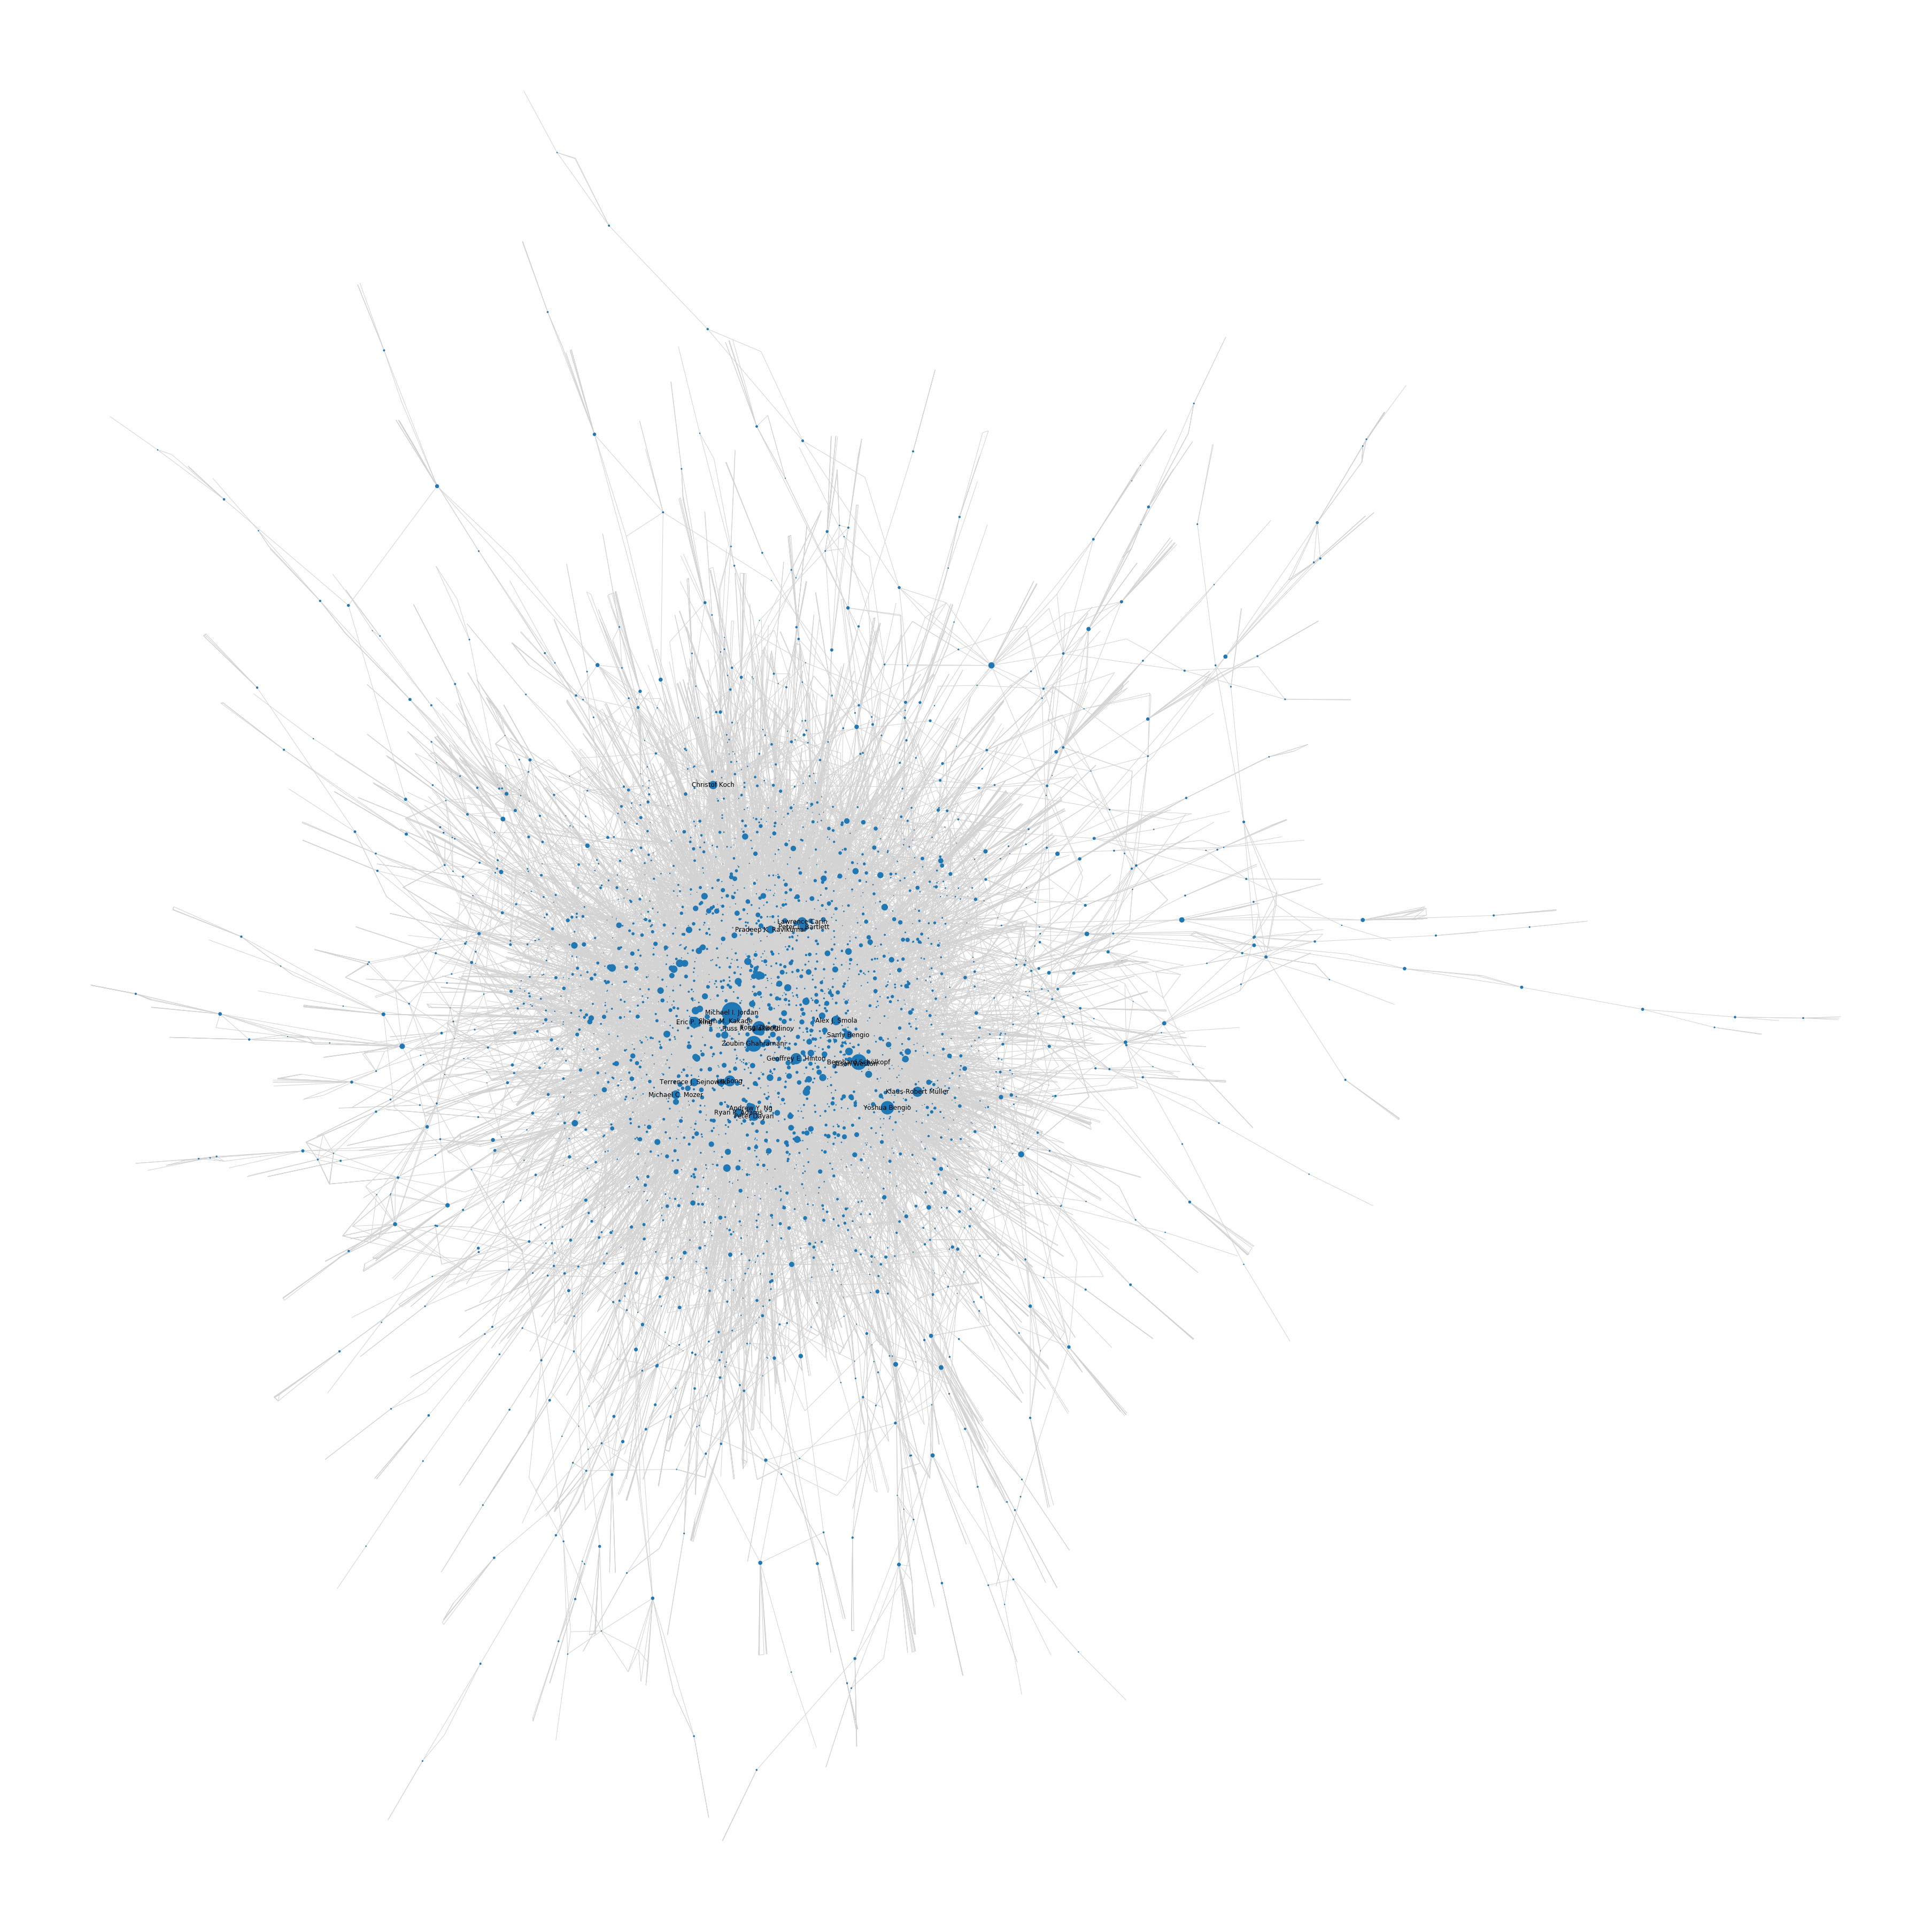

In [77]:
plt.figure(figsize=(50, 50))
nx.draw(graph.subgraph(largest_cc), node_size=node_size, edge_color='lightgray', labels=lables)

In [26]:
nx.average_shortest_path_length(graph.subgraph(largest_cc))

5.951291924390921

**clustering coefficient** is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterised by a relatively high density of ties.  
Here we compute the average clustering coefficient for the co-author network and get 0.7, which means the authors tend to co-operate together.

In [27]:
nx.average_clustering(graph.subgraph(largest_cc))

0.7009289800022787

In [28]:
nx.density(graph.subgraph(largest_cc))

0.0006096121538091715

**Construc a more sparse co-author graph**  
we filter the graph with edge weight bigger than 1. This means if two authors cooperate twice, we retain the edge between them, otherwise, we remove the edge between them.

In [79]:
G = nx.Graph(((source, target, attr) for source, target, attr in graph.edges(data=True) if attr['weight'] > 1))
nx.set_node_attributes(G, nodes.name.to_dict(), name='author')
component = pd.Series([len(i) for i in list(nx.connected_components(G))]).value_counts().sort_index()
component = pd.DataFrame(component).reset_index()
component.columns = ['component_size', 'number of components']
component

component_size  number of components
0                2                   208
1                3                    86
2                4                    43
3                5                    19
4                6                    12
5                7                     5
6                8                     7
7                9                     4
8               10                     3
9               11                     2
10              13                     3
11              14                     1
12              16                     1
13              17                     1
14              19                     1
15              26                     1
16              32                     1
17              43                     1
18            1321                     1

**We highlight the nodes with betweenness centrality of the top 5%**

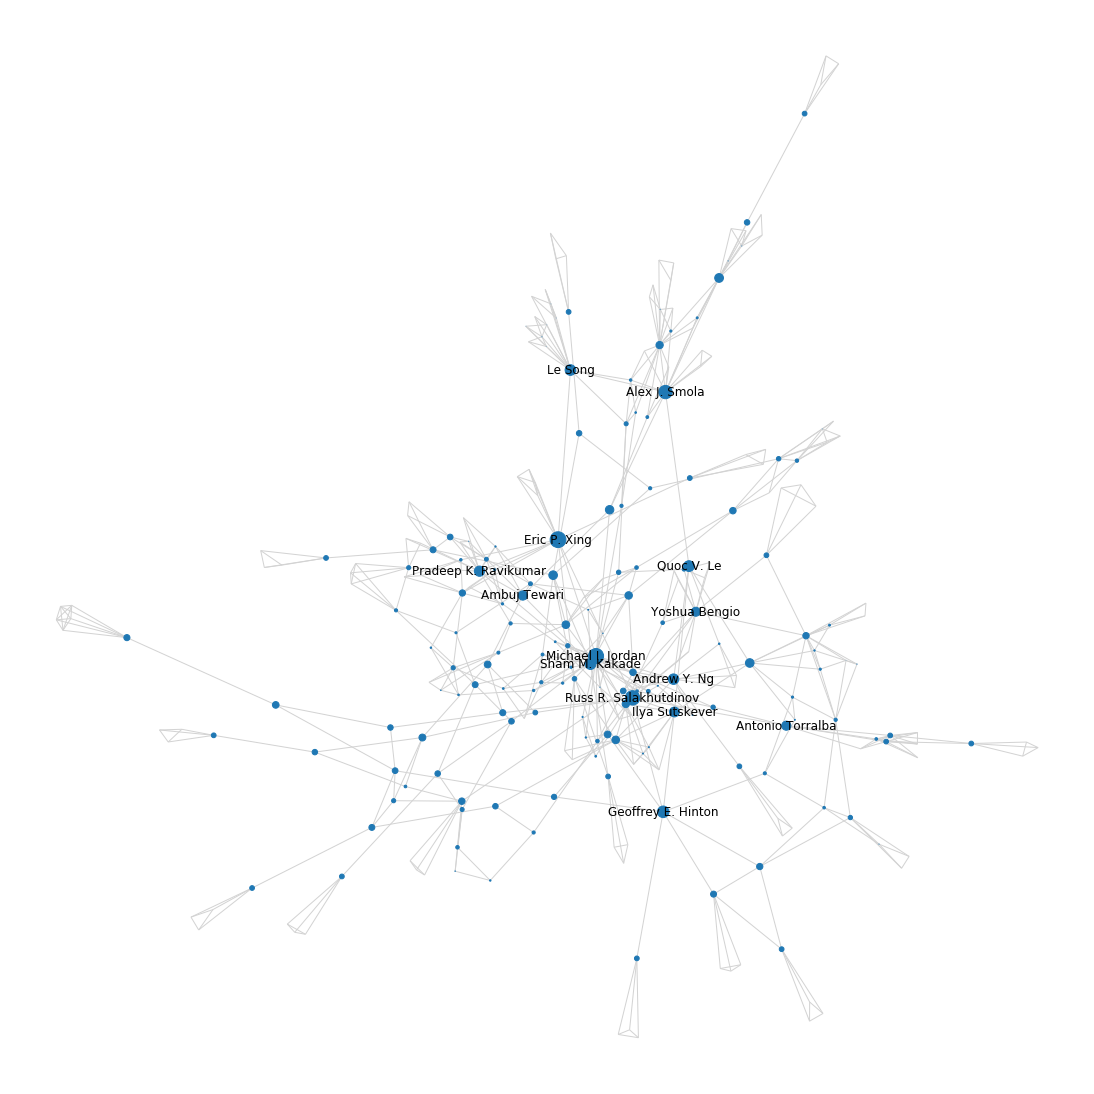

In [80]:
lc = max(nx.connected_components(G), key=len)
core = nx.k_core(G.subgraph(lc), k=3)
core = core.subgraph(max(nx.connected_components(core), key=len))
node_size = pd.Series(nx.betweenness_centrality(core))
labels = nx.get_node_attributes(core.subgraph(node_size[node_size.quantile(0.95) < node_size].index), 'author')
plt.figure(figsize=(15, 15))
pos= nx.layout.spring_layout(core)
nx.draw(core,pos=pos, edge_color='lightgray', node_size=node_size*1000, span=0.01, labels=labels, seed=2)
plt.savefig('figure/author_collab_large.pdf')